### LightGBMを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'c_mean_price':                'float32',
 'a_mean_price':                'float32',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'c_mean_sales_channel_id':     'float32',
 'a_mean_sales_channel_id':     'float32'
 }

In [26]:
# train data
train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
negative_num = 200
train_list = [dd.read_csv(f'./train_{date}_{negative_num}.csv', dtype=input_type).compute() for date in train_date_list]

In [27]:
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
valid = train_list[3].reset_index(drop=True)

In [28]:
# tmp
valid = dd.read_csv(f'./train_{train_date_list[3]}.csv', dtype=input_type).compute() 

In [29]:
train

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,a_mean_price,a_cv_total,a_cv_recent,a_mean_sales_channel_id
0,-9223352921020755230,111565001,False,False,False,0,1,24,202746,0.040322,...,5,99,1,1,62,1021,0.006917,4820,30,1.565353
1,-9223352921020755230,237347045,False,False,False,0,1,24,202746,0.040322,...,9,47,0,1,16,1002,0.032377,1161,46,1.448751
2,-9223352921020755230,478298005,False,False,False,0,1,24,202746,0.040322,...,5,152,2,1,66,1019,0.005727,950,4,1.086316
3,-9223352921020755230,493103035,False,False,False,0,1,24,202746,0.040322,...,5,212,5,4,44,1021,0.012818,346,10,1.835260
4,-9223352921020755230,523489015,False,False,False,0,1,24,202746,0.040322,...,3,152,2,1,66,1019,0.004495,1060,19,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28865283,9221980340157146437,929165002,False,True,True,0,4,57,243964,0.025733,...,1,31,0,1,15,1003,0.049191,437,179,1.000000
28865284,9221980340157146437,931869001,False,True,True,0,4,57,243964,0.025733,...,5,25,3,2,50,1010,0.042199,62,20,2.000000
28865285,9221980340157146437,935892001,False,True,True,0,4,57,243964,0.025733,...,11,105,0,1,62,1017,0.025006,332,332,2.000000
28865286,9221980340157146437,937138001,False,True,True,0,4,57,243964,0.025733,...,15,154,2,1,66,1019,0.016584,77,36,2.000000


In [30]:
valid

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,a_mean_price,a_cv_total,a_cv_recent,a_mean_sales_channel_id
0,-9223100958908512198,123173001,False,True,False,0,4,35,303672,0.028207,...,5,99,1,1,62,1021,0.012159,6556,78,1.292251
1,-9223100958908512198,266875001,False,True,False,0,4,35,303672,0.028207,...,5,100,1,1,62,1021,0.015419,3849,50,1.235905
2,-9223100958908512198,534164001,False,True,False,0,4,35,303672,0.028207,...,9,75,0,1,8,1005,0.032602,4060,44,1.859606
3,-9223100958908512198,536139068,False,True,False,0,4,35,303672,0.028207,...,19,106,1,1,62,1017,0.016651,171,163,1.912281
4,-9223100958908512198,547780001,False,True,False,0,4,35,303672,0.028207,...,5,36,3,2,51,1002,0.024229,7600,61,1.421316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232531,9223141695752178477,925290003,False,True,True,0,4,19,135002,0.024072,...,11,18,0,1,15,1012,0.033612,37,37,2.000000
232532,9223141695752178477,928206001,False,True,True,0,4,19,135002,0.024072,...,9,23,0,1,15,1010,0.033524,36,0,2.000000
232533,9223141695752178477,928802001,False,True,True,0,4,19,135002,0.024072,...,15,154,2,1,66,1019,0.011423,44,7,1.704545
232534,9223141695752178477,935694002,False,True,True,0,4,19,135002,0.024072,...,-1,44,0,1,6,1005,0.024767,29,29,2.000000


In [31]:
del train_list
gc.collect()

0

## Preprocess

In [32]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,a_mean_price,a_cv_total,a_cv_recent,a_mean_sales_channel_id
0,-9223352921020755230,111565001,False,False,False,0,1,24,202746,0.040322,...,5,99,1,1,62,1021,0.006917,4820,30,1.565353
1,-9223352921020755230,237347045,False,False,False,0,1,24,202746,0.040322,...,9,47,0,1,16,1002,0.032377,1161,46,1.448751
2,-9223352921020755230,478298005,False,False,False,0,1,24,202746,0.040322,...,5,152,2,1,66,1019,0.005727,950,4,1.086316
3,-9223352921020755230,493103035,False,False,False,0,1,24,202746,0.040322,...,5,212,5,4,44,1021,0.012818,346,10,1.835260
4,-9223352921020755230,523489015,False,False,False,0,1,24,202746,0.040322,...,3,152,2,1,66,1019,0.004495,1060,19,1.000000


In [33]:
# queryの準備, customer_idごとにsortする, lightGBMを使うときに必要
query_list_train = train['customer_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid['customer_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [34]:
query_list_train.head()

-9223352921020755230    197
-9223343869995384291    193
-9223290575350349271    194
-9223194771605040811    196
-9223120303940804728    390
Name: customer_id, dtype: int64

In [35]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [36]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [37]:
# labelエンコードは前段で済んでいる

In [38]:
train_x

,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_cv_total,c_cv_recent,c_mean_sales_channel_id,...,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,a_mean_price,a_cv_total,a_cv_recent,a_mean_sales_channel_id
0,False,False,0,1,24,202746,0.040322,10,0,1.00,...,5,99,1,1,62,1021,0.006917,4820,30,1.565353
1,False,False,0,1,24,202746,0.040322,10,0,1.00,...,9,47,0,1,16,1002,0.032377,1161,46,1.448751
2,False,False,0,1,24,202746,0.040322,10,0,1.00,...,5,152,2,1,66,1019,0.005727,950,4,1.086316
3,False,False,0,1,24,202746,0.040322,10,0,1.00,...,5,212,5,4,44,1021,0.012818,346,10,1.835260
4,False,False,0,1,24,202746,0.040322,10,0,1.00,...,3,152,2,1,66,1019,0.004495,1060,19,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28865283,True,True,0,4,57,243964,0.025733,32,2,1.25,...,1,31,0,1,15,1003,0.049191,437,179,1.000000
28865284,True,True,0,4,57,243964,0.025733,32,2,1.25,...,5,25,3,2,50,1010,0.042199,62,20,2.000000
28865285,True,True,0,4,57,243964,0.025733,32,2,1.25,...,11,105,0,1,62,1017,0.025006,332,332,2.000000
28865286,True,True,0,4,57,243964,0.025733,32,2,1.25,...,15,154,2,1,66,1019,0.016584,77,36,2.000000


## Training

In [39]:
# LightGBM
import lightgbm as lgb

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'ndcg_eval_at': [12],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 100

In [40]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

In [41]:
lgb_train

In [42]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval])

[LightGBM] [Info] Total groups: 133883, total data: 28865288
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.393751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 28865288, number of used features: 25
[LightGBM] [Info] Total groups: 68984, total data: 6965590
[1]	train's map@12: 0.07396	valid's map@12: 0.113064
[2]	train's map@12: 0.0721827	valid's map@12: 0.100148
[3]	train's map@12: 0.0726175	valid's map@12: 0.105424
[4]	train's map@12: 0.0718504	valid's map@12: 0.10243
[5]	train's map@12: 0.0732532	valid's map@12: 0.106926
[6]	train's map@12: 0.0746857	valid's map@12: 0.109984
[7]	train's map@12: 0.0746558	valid's map@12: 0.109356
[8]	train's map@12: 0.0736354	valid's map@12: 0.105321
[9]	train's map@12: 0.0745572	valid's map@12: 0.106663
[10]	train's map@12: 0.075572

In [43]:
model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7f1a7036d430>>

In [44]:
model.best_iteration

0

In [45]:
model.feature_name()

['FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_mean_sales_channel_id']

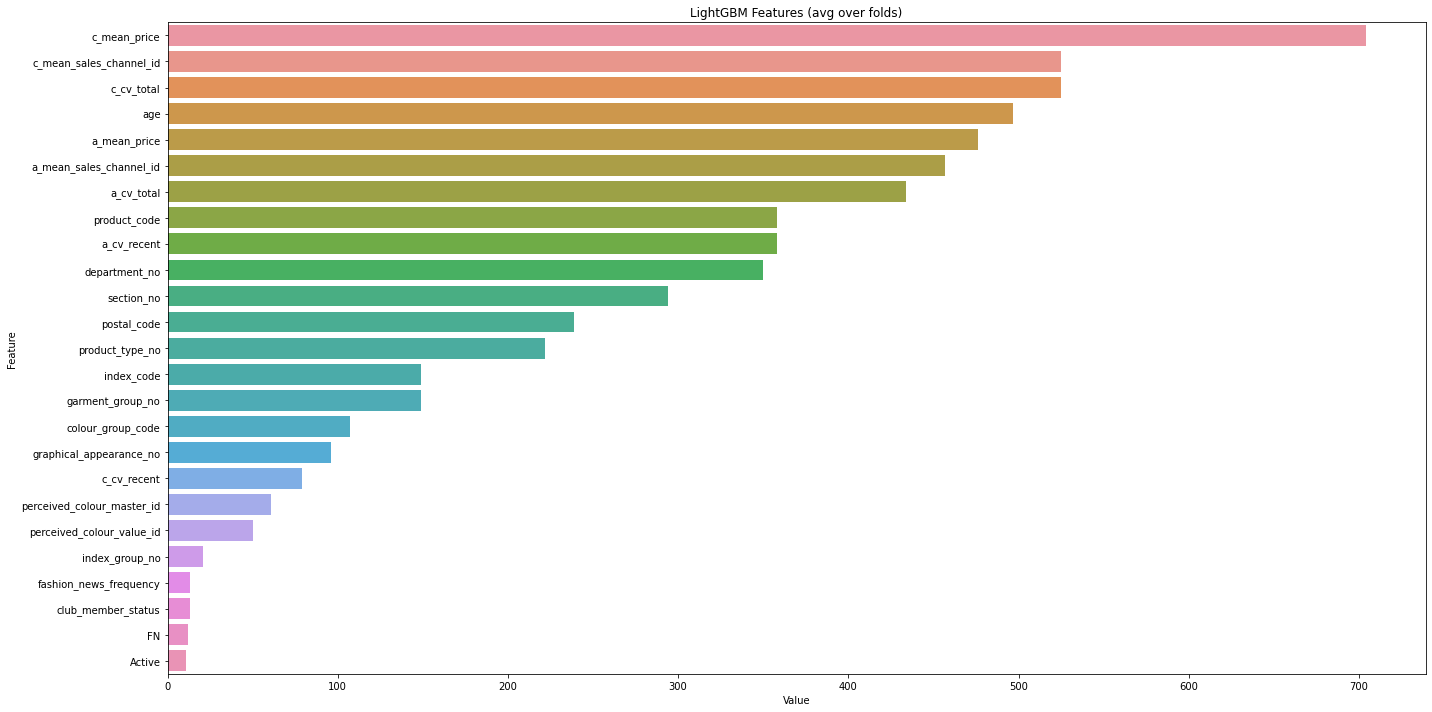

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test

In [21]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

7589

In [22]:
# test data
test = dd.read_csv('../input/h-m-training-and-testing-data/test.csv', dtype=input_type).compute()
test

,customer_id,article_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_cv_total,...,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,a_mean_price,a_cv_total,a_cv_recent,a_mean_sales_channel_id
0,-7200416642310594310,929275001,False,False,0,2,25,57312,0.030255,86,...,5,51,0,1,15,1009,0.000000,0,0,0.000000
1,-7200416642310594310,918522001,False,False,0,2,25,57312,0.030255,86,...,9,31,0,1,15,1003,0.041446,364,364,1.766484
2,-7200416642310594310,573085042,False,False,0,2,25,57312,0.030255,86,...,12,51,0,1,15,1009,0.032649,2936,77,1.723433
3,-7200416642310594310,934835001,False,False,0,2,25,57312,0.030255,86,...,5,33,3,2,53,1005,0.000000,0,0,0.000000
4,-7200416642310594310,850917001,False,False,0,2,25,57312,0.030255,86,...,9,22,0,1,11,1010,0.024427,7585,369,1.780224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234908,-1516792180973952447,923758001,False,False,3,2,65,13927,0.084729,1,...,9,23,0,1,15,1010,0.033881,1,1,2.000000
234909,-1516792180973952447,924243001,False,False,3,2,65,13927,0.084729,1,...,1,31,0,1,15,1003,0.041123,149,114,1.000000
234910,-1516792180973952447,751471001,False,False,3,2,65,13927,0.084729,1,...,5,51,0,1,15,1009,0.032275,17130,724,1.693345
234911,-1516792180973952447,863646001,False,False,3,2,65,13927,0.084729,1,...,5,31,0,1,15,1003,0.033121,318,207,1.411950


In [23]:
test.sort_index(inplace=True)

In [24]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [25]:
del query_list_train, query_list_valid, lgb_train, lgb_eval, params, feature_imp
gc.collect()

0

In [26]:
test

,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_cv_total,c_cv_recent,c_mean_sales_channel_id,...,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,a_mean_price,a_cv_total,a_cv_recent,a_mean_sales_channel_id
0,False,False,0,2,25,57312,0.030255,86,0,1.94186,...,5,51,0,1,15,1009,0.000000,0,0,0.000000
0,True,True,0,4,21,250524,0.021932,20,0,2.00000,...,2,57,3,2,53,1009,0.040611,18117,529,1.970525
0,False,False,0,2,21,60758,0.021680,11,0,1.00000,...,1,31,0,1,15,1003,0.031962,4,3,1.750000
0,False,False,0,2,24,287722,0.026923,19,0,2.00000,...,2,59,3,2,57,1016,0.046498,7349,324,1.916723
0,False,False,0,2,61,217318,0.017992,2,0,1.00000,...,5,51,0,1,15,1009,0.033083,2135,757,1.696956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237805,True,True,0,4,30,81853,0.015237,16,0,2.00000,...,6,31,0,1,15,1003,0.049923,99,99,2.000000
237806,True,True,0,4,30,81853,0.015237,16,0,2.00000,...,2,59,3,2,57,1016,0.046498,7349,324,1.916723
237807,True,True,0,4,30,81853,0.015237,16,0,2.00000,...,5,99,1,1,62,1021,0.012297,15929,332,1.320987
237808,True,True,0,4,30,81853,0.015237,16,0,2.00000,...,5,47,0,1,16,1002,0.016261,9606,331,1.698209


In [27]:
pred = model.predict(test, num_iteration=100)
pred.shape, test.shape

((41159400,), (41159400, 25))

In [28]:
del test, model
gc.collect()

4

In [29]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [49]:
sub1 = pd.concat([test_id, pred], axis=1)

In [50]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [51]:
sub1

,customer_id,article_id,score
0,-7200416642310594310,929275001,0.050730
1,-8214047830294726331,448509014,0.170441
2,404745439107207066,915529005,-0.479741
3,859005790229287778,714790020,0.048923
4,-6820622709429962402,751471043,0.033703
...,...,...,...
41159395,8412497449490976274,896169005,-0.493043
41159396,8412497449490976274,714790020,-0.244331
41159397,8412497449490976274,158340001,-0.030595
41159398,8412497449490976274,768912001,0.091806


In [55]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [56]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [57]:
sub1['prediction'].apply(len)

0          30
1          30
2          30
3          30
4          30
           ..
1371975    30
1371976    30
1371977    30
1371978    30
1371979    30
Name: prediction, Length: 1371980, dtype: int64

In [58]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [59]:
sub1['prediction']

0          [924243001, 918292001, 909370001, 915526001, 9...
1          [903926002, 930380001, 896169005, 929275001, 9...
2          [751471043, 579541001, 751471038, 928206001, 8...
3          [788575002, 715624001, 448509014, 866731001, 7...
4          [930380001, 896169002, 896169005, 929275001, 9...
                                 ...                        
1371975    [448509014, 762846006, 806131012, 867969003, 7...
1371976    [924243001, 918292001, 715624001, 866731001, 9...
1371977    [852584001, 714790020, 785034009, 896169005, 8...
1371978    [579541001, 751471043, 714790020, 751471038, 8...
1371979    [914449001, 915529003, 785034009, 714790020, 9...
Name: prediction, Length: 1371980, dtype: object

In [60]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [61]:
sub1

,customer_id,prediction
0,-9223352921020755230,0924243001 0918292001 0909370001 0915526001 09...
1,-9223343869995384291,0903926002 0930380001 0896169005 0929275001 09...
2,-9223321797620987725,0751471043 0579541001 0751471038 0928206001 08...
3,-9223319430705797669,0788575002 0715624001 0448509014 0866731001 07...
4,-9223308614576639426,0930380001 0896169002 0896169005 0929275001 09...
...,...,...
1371975,9223319300843860958,0448509014 0762846006 0806131012 0867969003 07...
1371976,9223333063893176977,0924243001 0918292001 0715624001 0866731001 09...
1371977,9223345314868180224,0852584001 0714790020 0785034009 0896169005 08...
1371978,9223357421094039679,0579541001 0751471043 0714790020 0751471038 08...


## Submit

In [62]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [63]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [64]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [65]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [66]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [67]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [68]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0924243001 0929165002 0918525001 0919273002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0896169005 0911699002 0918292001 0894780001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0896169005 0924243002 0923758001 0918292001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0896169002 0896169005 0751471038 0751471043 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0918522001 0579541001 0896169002 0930380001 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0866731001 0918292001 0448509014 0714790020 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0715624001 0788575002 0762846027 0866731001 08...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0788575002 0448509014 0866731001 0714790020 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0715624001 0448509014 0918292001 0714790020 08...


In [ ]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission.csv', index=False)

(1371980, 2)
